## Autoencoder in Tensorflow
Implementation of a symetrical deep autoencoder with weight-tying using keras

In [0]:
import numpy as np
import tensorflow as tf
import tarfile
import io
from tensorflow import keras
from google.cloud import storage
from tensorflow.keras.models import Model 
from keras import backend as K
from PIL import Image
from matplotlib import pylab as plt

Using TensorFlow backend.


#### Connect with GCS bucket

In [0]:
bucket_name = "dataproc-staging-us-central1-759291875656-wohgf1sk"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
file_prefix = "data/"
blobs = bucket.list_blobs(prefix=file_prefix, delimiter = '/')

In [0]:
# list files in folder
for blob in blobs:
    print(blob.name)

#### Download file from blob

In [0]:
file_name = "val_data.tar"
blob = bucket.get_blob(file_prefix + file_name)
blob.download_to_filename("small_data.tar")

In [0]:
# test small amount of images
TEST_NUM_IMAGES = 50000

image_byte = []
tar_file = tarfile.open("/content/drive/My Drive/10605 Term Project/data_val_data.tar")

num = 0
for member in tar_file.getmembers():
    if num <= TEST_NUM_IMAGES:
        f = tar_file.extractfile(member)
        if f is not None:
            content = f.read()
            image_byte.append(content)
        num += 1
    else:
        break
tar_file.close()

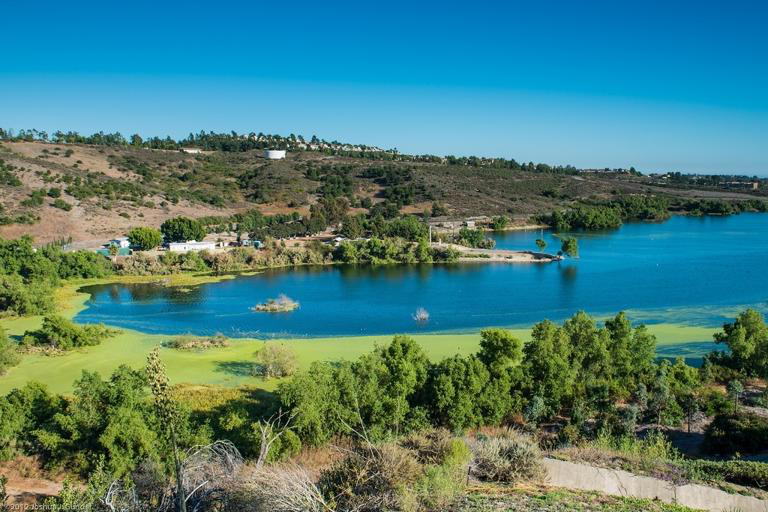

In [0]:
# visualize data
data = image_byte
Image.open(io.BytesIO(data[0]))

In [0]:
def img_to_ndarray(img_data, img_dim):
    """ 
  Resize image so that it has height dim_h and flatten the image
  Args:
    img_data: (bytes) image data
    img_dim: typle(width, height)
  Returns:
    img: (np array) the resized and flattened image
    """
    img = Image.open(io.BytesIO(img_data))
    img = img.convert(mode = 'L') # convert to grey scale
    img = img.resize(img_dim)
    return np.array(img)

# numpy memmap


In [0]:
img_array = np.asarray([img_to_ndarray(img, img_dim=(32, 32)) for img in data])

In [0]:
# img_array = img_array.reshape(img_array.shape[0], 64, 64, 1)
# img_array.shape
img_array = img_array / 255.0

(36500, 32, 32)


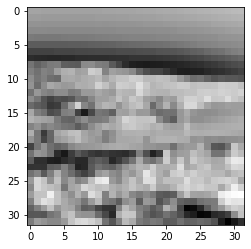

In [0]:
plt.imshow(img_array[0], cmap='Greys')
print(img_array.shape)

## AutoencoderBuilder
The builder class abstracts away the process of building a multi-layered, symmetrical tied-weight autoencoder

In [0]:
class AutoencoderBuilder():
  """
  Builder for a multi-layer, symetrical autoencoder with weight-tying
  """
  def __init__(self, input_shape, encoder_layer_sizes, activation='relu'):
    """
    The decoder layer sizes will be symetrical of the encoder. The last layer
    of the encoding layer describes the bottle-neck layer or the latent 
    representation of the input. Note: the input data must be normalized. 
    The input shape should be (rows, cols, channels)
    """
    self.input_shape = input_shape
    self.encoder_layer_sizes = encoder_layer_sizes
    self.activation = activation
    
  def build(self):
    """Builds the autoencoder"""
    encoder_layers = self._encoder()
    decoder_layers = self._decoder(encoder_layers)
    return keras.models.Sequential(encoder_layers + decoder_layers)

  def _encoder(self):
    """Builds the encoding layers"""
    layers = []
    layers.append(keras.layers.Flatten(input_shape=(self.input_shape)))
    for size in self.encoder_layer_sizes:
      layers.append(keras.layers.Dense(size, activation=self.activation, 
                                       name=f'layer_size_{size}'))
    return layers

  def _decoder(self, encoder_layers):
    """
    Builds the decoding layers by transposing encoder layers such
    that the encoder and decoder share weights
    """
    layers = []
    for el in encoder_layers[:1:-1]:
      layers.append(DenseTranspose(el, activation=self.activation))
    layers.append(DenseTranspose(encoder_layers[1], activation='sigmoid'))
    layers.append(keras.layers.Reshape(self.input_shape))
    return layers

### Pooling layer to reduce size of the image

In [0]:
    def pooling_layer(input_shape, pool_size):
      return keras.models.Sequential(
          keras.layers.AveragePooling2D(pool_size=pool_size,
                                        strides=None,
                                        padding='valid',
                                        data_format=None,
                                        input_shape=(input_shape)))

## Custom weight-tying layers

In [0]:
# weight-tying dense (transpose) layer
# cite: https://mc.ai/a-beginners-guide-to-build-stacked-autoencoder-and-tying-weights-with-it/

class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    super().__init__(**kwargs)
    self.dense = dense
    self.activation = keras.activations.get(activation)
  
  def build(self, input_shape):
    super().build(input_shape)
    self.bias = self.add_weight(name="bias",
                                shape=(self.dense.input_shape[-1]),
                                initializer="zeros")
  
  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.bias)

#### MNIST data loading and preprocessing

In [0]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# normalizing the data
x_train, x_test = x_train / 255.0, x_test /255.0

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
batch_size = 128
epochs=20
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

### Autoencoder Training Loop with pooling layer

In [0]:
def train_ae(data, input_shape, pool_size, 
             encoder_layer_sizes, batch_size, epochs):
  pool = pooling_layer(input_shape=input_shape, pool_size=pool_size)
  pooled_data = pool(data)
  reduce_size_shape = pooled_data[1:]
  ae_builder = AutoencoderBuilder(input_shape=reduce_size_shape,
                                encoder_layer_sizes=[98, 49],
                                activation='relu')
  ae = ae_builder.build()
  print(ae.summary())
  ae.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
  ae.fit(pooled_data, pooled_data, 
         batch_size=100,
         epochs=20)
  return ae

In [0]:
# ae = train_ae(img_array, input_shape=(64, 64, 1), pool_size=(4,4),
#               encoder_layer_sizes=[128, 64], batch_size=50, epochs=100)

### Simple Autoencoder Training Loop

In [0]:
from keras.layers import LeakyReLU

In [0]:
ae_builder = AutoencoderBuilder(input_shape=(32, 32),
                                encoder_layer_sizes=[512, 256, 128],
                                activation='selu')
ae = ae_builder.build()
ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
layer_size_512 (Dense)       (None, 512)               524800    
_________________________________________________________________
layer_size_256 (Dense)       (None, 256)               131328    
_________________________________________________________________
layer_size_128 (Dense)       (None, 128)               32896     
_________________________________________________________________
dense_transpose_6 (DenseTran (None, 256)               33152     
_________________________________________________________________
dense_transpose_7 (DenseTran (None, 512)               131840    
_________________________________________________________________
dense_transpose_8 (DenseTran (None, 1024)             

In [0]:
ae.compile(optimizer='adam',
           loss='mse',
           metrics=['accuracy'])
ae.fit(img_array, img_array, 
       batch_size=500,
       epochs=500)

Epoch 1/500
73/73 [==============================] - 1s 9ms/step - loss: 0.0466 - accuracy: 0.0708
Epoch 2/500
73/73 [==============================] - 1s 9ms/step - loss: 0.0245 - accuracy: 0.0842
Epoch 3/500
73/73 [==============================] - 1s 9ms/step - loss: 0.0152 - accuracy: 0.1056
Epoch 4/500
73/73 [==============================] - 1s 9ms/step - loss: 0.0135 - accuracy: 0.1171
Epoch 5/500
73/73 [==============================] - 1s 10ms/step - loss: 0.0120 - accuracy: 0.1282
Epoch 6/500
73/73 [==============================] - 1s 10ms/step - loss: 0.0115 - accuracy: 0.1350
Epoch 7/500
73/73 [==============================] - 1s 10ms/step - loss: 0.0109 - accuracy: 0.1421
Epoch 8/500
73/73 [==============================] - 1s 9ms/step - loss: 0.0099 - accuracy: 0.1500
Epoch 9/500
73/73 [==============================] - 1s 9ms/step - loss: 0.0094 - accuracy: 0.1561
Epoch 10/500
73/73 [==============================] - 1s 10ms/step - loss: 0.0092 - accuracy: 0.1608
Epoch

### Visualized Compressed Images

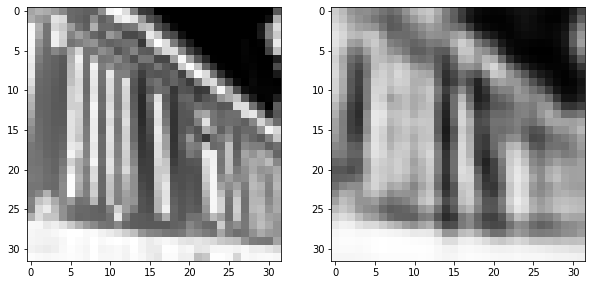

In [0]:
idx = 14
test_image = img_array[idx].reshape(1, 32, 32)
reconstr_image = ae(test_image)
# plt.imshow(reconstr_image[0], cmap='Greys')

fig=plt.figure(figsize=(10, 5))
columns = 2
rows = 1

figures = [test_image[0], reconstr_image[0]]

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  plt.imshow(figures[i-1], cmap='Greys')
plt.show()

### Extract trained encoder for dimension reduction

In [0]:
encoder_layers = ["layer_size_49"]
def build_encoder(model, encoder_layers):
  output = [model.get_layer(name).output for name in encoder_layers]
  encoder = Model(model.input, output)
  return Model(model.input, output)

In [0]:
encoder = build_encoder(ae, encoder_layers)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_input (InputLayer)   [(None, 14, 14, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 196)               0         
_________________________________________________________________
layer_size_98 (Dense)        (None, 98)                19306     
_________________________________________________________________
layer_size_49 (Dense)        (None, 49)                4851      
Total params: 24,157
Trainable params: 24,157
Non-trainable params: 0
_________________________________________________________________


In [0]:
def dim_reduction(data, encoder, pool_size, input_shape):
  pool = pooling_layer(input_shape=input_shape, pool_size=pool_size) # pool_size should be identical to training data
  data= pool(data)
  reduce_size_shape = data.shape[1:]
  return encoder(data)

In [0]:
result = dim_reduction(data=x_test, encoder=encoder, pool_size=pool_size, input_shape=input_shape)
result

<tf.Tensor: shape=(10000, 49), dtype=float32, numpy=
array([[0.56334925, 3.1370628 , 3.2457414 , ..., 0.75537527, 1.1877496 ,
        1.6741505 ],
       [1.711744  , 2.5826445 , 0.9489123 , ..., 1.2208486 , 2.3426886 ,
        3.7598712 ],
       [1.8585253 , 1.254968  , 3.926601  , ..., 1.9116914 , 2.3137083 ,
        1.5274441 ],
       ...,
       [1.2636708 , 5.548594  , 4.736193  , ..., 2.163463  , 1.7429706 ,
        2.46935   ],
       [4.08931   , 2.0583992 , 2.0444398 , ..., 1.6541221 , 1.3013427 ,
        2.729029  ],
       [3.829256  , 2.1624181 , 4.2957363 , ..., 3.8994286 , 2.2566168 ,
        4.4342227 ]], dtype=float32)>